<a href="https://colab.research.google.com/github/thesahibnanda/AvataarAssignmentSahibNanda/blob/main/Avataar_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook**

## Installing All Libraries

In [ ]:
! pip install -qU diffusers transformers accelerate safetensors opencv-python torch torchvision torchaudio diffusers
! pip install -qU git+https://github.com/facebookresearch/segment-anything
! pip install -qU opencv-python-headless
! pip install -qU huggingface_hub
! pip install -qU git+https://github.com/sberbank-ai/Real-ESRGAN.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 26.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Downloading SAM Model Weights

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-10-02 13:07:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.96, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   179MB/s    in 17s     

2024-10-02 13:08:12 (144 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



## Import All Libs

In [ ]:
import os
import shutil
import time
import torch as th
import numpy as np
from google.colab import files
from PIL import Image
import random
from torchvision import models, transforms
import cv2
import base64
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from diffusers import AutoPipelineForInpainting, DEISMultistepScheduler, StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
import IPython.display as iPython
import requests
from RealESRGAN import RealESRGAN
from IPython.display import Video
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast()


## Download Image Using URL

In [ ]:
def DownloadImage(url, genPath):
    directory = os.path.dirname(genPath)
    if directory:
        os.makedirs(directory, exist_ok=True)
    response = requests.get(url, stream=True)

    if response.status_code == 200:
        with open(genPath, 'wb') as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        return os.path.abspath(genPath)
    else:
        return None

In [ ]:
Image_Path = DownloadImage(input("Enter URL For Input Image: "), r"input.jpg")

Enter URL For Input Image: https://img.freepik.com/free-psd/3d-rendering-lion-isolated_23-2151673509.jpg


## Function To Show Image

In [ ]:
def ShowImage(ImagePath):
    img = mpimg.imread(ImagePath)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

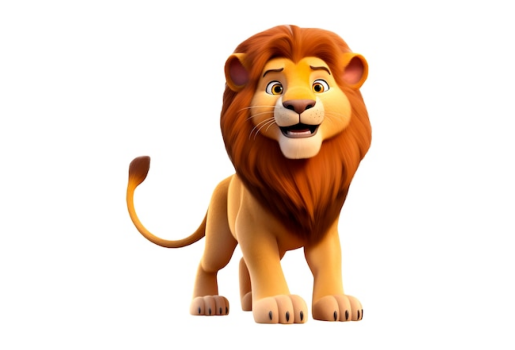

In [ ]:
ShowImage(Image_Path)

## Function to Create Mask

In [ ]:
def GenerateSegmentationMask(inputImagePath, outputMaskPath, modelWeightsPath) -> str:
    input_image = cv2.imread(inputImagePath)
    sam = sam_model_registry["vit_h"](checkpoint=modelWeightsPath)
    sam.to(device="cuda")
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(input_image)
    object_mask = masks[0]['segmentation']
    mask_image = (object_mask.astype(np.uint8) * 255)
    h, w = mask_image.shape
    center_region = mask_image[h//4: 3*h//4, w//4: 3*w//4]
    center_mean = np.mean(center_region)
    if center_mean > 127:
        mask_image = cv2.bitwise_not(mask_image)

    kernel = np.ones((3,3),np.uint8)
    mask_image = cv2.morphologyEx(mask_image, cv2.MORPH_CLOSE, kernel)

    cv2.imwrite(outputMaskPath, mask_image)

    return os.getcwd() + "/" + outputMaskPath

In [ ]:
Mask_Image_Path = GenerateSegmentationMask(Image_Path, "mask.jpg", r"/content/sam_vit_h_4b8939.pth")

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


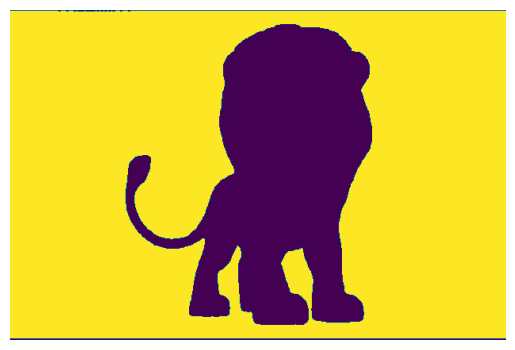

In [ ]:
ShowImage(Mask_Image_Path)

## Use Seed

In [ ]:
generator = th.manual_seed(100)

## Load Images

In [ ]:
image = load_image(Image_Path)
maskImage = load_image(Mask_Image_Path)

## Get Prompt

In [ ]:
textPrompt = input("Enter Prompt: ")
textPrompt += " {{good lighting and make it great}} {{make it highly majestic}}"
negPrompt = "{{ugly}} {{bad}} {{worst}} {{bad}}"

Enter Prompt: the object should be in an animated majestic purple and blue forest which is very beautiful


## Load Inpainting Model

In [ ]:
pipe = AutoPipelineForInpainting.from_pretrained('Lykon/dreamshaper-8-inpainting', torch_dtype=th.float16, variant="fp16")
pipe.scheduler = DEISMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/608M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/767 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Generate Model Using Inpainting Model

In [ ]:
Made_Image = pipe(textPrompt, negative_prompt=negPrompt, image=image, mask_image=maskImage, generator=generator, num_inference_steps=200).images[0]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
Made_Image_Path = "madebymodel.png"
Made_Image.save(Made_Image_Path)

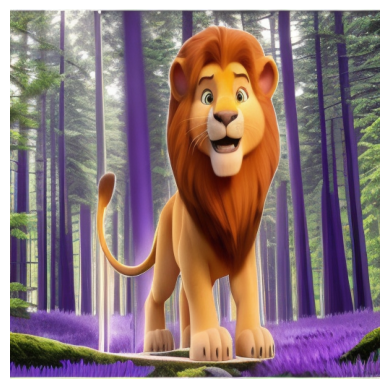

In [ ]:
ShowImage(Made_Image_Path)

## Enhance Image Using Super Resolution GAN (Generative Adversial Network)

In [ ]:
SRGAN_Model =  RealESRGAN(th.device('cuda' if th.cuda.is_available() else 'cpu'), scale=4)
SRGAN_Model.load_weights('weights/RealESRGAN_x4.pth', download=True)
SRGAN_Model_Image = SRGAN_Model.predict(Image.open(Made_Image_Path).convert('RGB'))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'cached_download' (from 'huggingface_hub.file_download') is deprecated and will be removed from version '0.26'. Use `hf_hub_download` instead.
  warnings.warn(warning_message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:672: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


RealESRGAN_x4.pth:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

Weights downloaded to: weights/RealESRGAN_x4.pth


/usr/local/lib/python3.10/dist-packages/RealESRGAN/model.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)


In [ ]:
SRGAN_Model_Image_Path = "srgan.png"
SRGAN_Model_Image.save(SRGAN_Model_Image_Path)

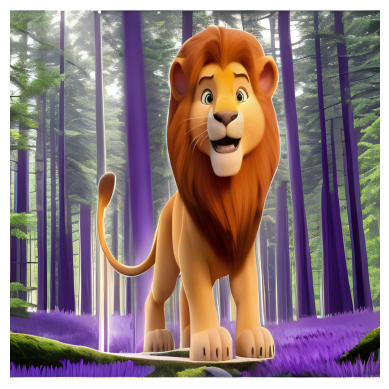

In [ ]:
ShowImage(SRGAN_Model_Image_Path)

## Make Video From Image

In [ ]:
pipeline = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=th.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()

model_index.json:   0%|          | 0.00/496 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/3.05G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

image_encoder/config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/196M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
image = load_image(SRGAN_Model_Image_Path)

In [ ]:
generator = th.manual_seed(42)

In [ ]:
frames = pipeline(image, decode_chunk_size=9, generator=generator).frames[0]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
export_to_video(frames, "Video.mp4", fps=10)

'Video.mp4'

In [ ]:
Video(r"/content/Video.mp4", embed=True, width=600, height=400)